# Temporal algebra

Veronica Andreo  
2024-07-24

In this third part of the time series tutorials, we will go through
different temporal algebra examples. There are five modules within the
temporal framework that allow us to perform temporal map algebra on
different types of data:
[t.rast.mapcalc](https://grass.osgeo.org/grass-stable/manuals/t.rast.mapcalc.html),
[t.rast.algebra](https://grass.osgeo.org/grass-stable/manuals/t.rast.algebra.html),
[t.rast3d.mapcalc](https://grass.osgeo.org/grass-stable/manuals/t.rast3d.mapcalc.html),
[t.rast3d.algebra](https://grass.osgeo.org/grass-stable/manuals/t.rast3d.algebra.html),
and
[t.vect.algebra](https://grass.osgeo.org/grass-stable/manuals/t.vect.algebra.html).
We will focus on the raster oriented tools in this tutorial.

> **Setup**
>
> This tutorial can be run locally or in Google Colab. However, make
> sure you install GRASS 8.4+, download the LST sample data and set up
> your project as explained in the
> [first](time_series_management_and_visualization.qmd) time series
> tutorial.

## What tool to use?

Both
[t.rast.mapcalc](https://grass.osgeo.org/grass-stable/manuals/t.rast.mapcalc.html)
and
[t.rast.algebra](https://grass.osgeo.org/grass-stable/manuals/t.rast.algebra.html)
allow us to perform spatio-temporal operations on temporally sampled
maps of raster time series (STRDS). Also, both tools support spatial and
temporal functions.

Spatial operators and functions are those used in
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html).

Temporal internal variables supported for both relative and absolute
time include: `td()` (time delta), `start_time()` and `end_time()`.
There are also several useful internal temporal variables supported
especially for absolute time, e.g.: `start_doy()`, `start_year()`,
`start_month()` and so on.

Both *t.rast.mapcalc* and *t.rast.algebra* support temporal operations.
However, only *t.rast.algebra* is effectively temporally aware;
*t.rast.mapcalc* is mostly a wrapper around *r.mapcalc*. Indeed,
*t.rast.algebra* is able to perform a wide range of temporal operations
based on the temporal topology of maps within STRDS. Supported
operators, relations and functions are shown in the table below.

| Category | Examples |
|----------------------|--------------------------------------------------|
| Temporal operators | `u` (union), `i` (intersection), `l` (left reference), etc. |
| Temporal relations | `equals`, `during`, `contains`, `starts`, etc. |
| Temporal selection | `:`, `!:` |
| Temporal functions | `td()`, `start_time()`, `start_doy()`, `#`, `tmap()`, `map()`, `t_snap()`, `buff_t()`, `t_shift()`, etc. |
| Temporal neighborhood modifier | `[x,y,t]` |
| Spatial operators | `+`, `-`, `*`, `/`, `%` |
| Spatial functions | `abs(x)`, `float(x)`, `int(x)`, `log(x)`, `round(x)`, `isnull(x)`, `null()`, etc. |

They can all be combined in nested expressions with conditions
statements to create spatio-temporal operators! In general, expressions
have the following structure:
`{"spatial or select operator", "temporal relations", "temporal operator"}`
and they can be combined with conditional statements such as:
`if(topologies, conditions, A, B)` where A and B can be either space
time datasets or expressions (e.g., A+B). Just for illustration
purposes, let’s see some examples from the manual page.

| Expression | Description |
|----------------------|--------------------------------------------------|
| `C = A {+,equal,l} B` | `C` will have the same time stamps as `A` and will be `A + B` for maps with equal time stamps. Equivalent to `C = A + B`. The default temporal relation is *equal* and the default temporal operator is *left reference*. |
| `C = if(start_date(A) < "2005-01-01", A + B)` | `C` will be `A + B` if the start date of `A` is earlier than January 1, 2005. This is an if-then conditional expression. |
| `C = if({equal}, A > 100 && A < 1600 {&&,equal} td(A) > 30, B)` | `C` will include all cells from `B` with equal temporal relations to `A`, if values of `A` are between 100 and 1600 in time intervals longer than 30 units. Equivalent to `C = if(A > 100 && A < 1600 && td(A) > 30, B)`. |
| `C = A {:, during} tmap(event)` | `C` will include all maps from `A` that occur *during* the temporal extent of the single map `event`. |
| `C = A * map(constant_value)` | `C` will include all raster maps from `A` multiplied by a raster map called `constant_value` (a map without a time stamp). |
| `B = if(A > 0.0 && A[-1] > 0.0 && A[-2] > 0.0, start_doy(A, 0), 0)` | `B` will contain the Day of Year (DOY) from `A` where three consecutive time intervals have values \> 0. Otherwise, `B` will contain 0. |

Let’s see some examples using the LST daily time series from northern
Italy. We start with something simple to refresh what we learnt in the
tutorial about [aggregations](time_series_aggregations.qmd).

## Anomalies

To estimate annual anomalies, we need the long term average ($Avg$) and
standard deviation ($SD$) of the whole series, and the annual averages
($Avg_i$). Then, we estimate the standardized anomalies as:

$$
StdAnom_i = \frac{Avg_i - Avg}{SD}
$$

Let’s first obtain the average and standard deviation for the series:

In [2]:
# Get general average and SD
methods=["average", "stddev"]

for me in methods:
    gs.run_command("t.rast.series",
                   input="lst_daily",
                   method=me,
                   output=f"lst_{me}",
                   nprocs=6)

and then the annual LST average:

In [3]:
# Get annual averages
gs.run_command("t.rast.aggregate",
               input="lst_daily",
               method="average",
               granularity="1 years",
               output="lst_annual_average",
               basename="lst_average",
               suffix="gran",
               nprocs=6)

We now use *t.rast.algebra* to estimate the anomalies.

In [4]:
# Estimate annual anomalies
expression="lst_annual_anomaly = (lst_annual_average - map(lst_average)) / map(lst_stddev)"

gs.run_command("t.rast.algebra",
               expression=expression,
               basename="lst_annual_anomaly",
               suffix="gran",
               nprocs=6) # change accordingly!

We set the *differences* color palette for the whole time series and
then create an animation.

In [5]:
# Set difference color table
gs.run_command("t.rast.colors",
               input="lst_annual_anomaly",
               color="difference")

In [6]:
# Animation of annual anomalies
anomalies = gj.TimeSeriesMap()
anomalies.add_raster_series("lst_annual_anomaly", fill_gaps=False)
anomalies.d_legend(color="black", at=(5, 50, 2, 6))
anomalies.show()

In [7]:
# Save animation
anomalies.save("anomalies.gif")

<figure>
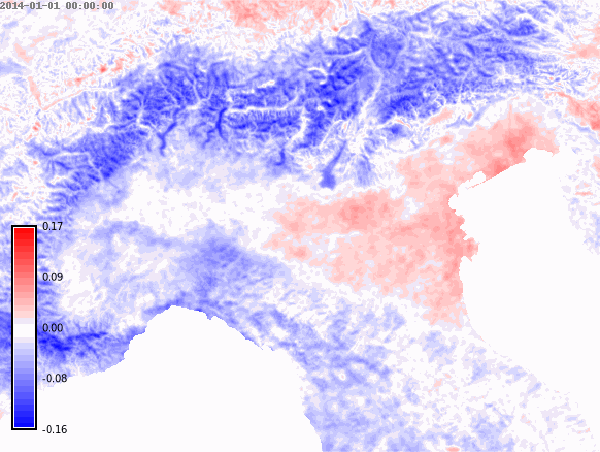
<figcaption aria-hidden="true">Animation of standardized
anomalies</figcaption>
</figure>

## Month with maximum LST

We will use *t.rast.mapcalc* to obtain the month when the maximum LST
occurred during our study period. We already estimated the map with the
maximum LST in the [temporal aggregations](time_series_aggregations.qmd)
tutorial, but let’s refresh our memories:

In [8]:
gs.run_command("t.rast.series",
               input="lst_daily",
               output=f"lst_maximum",
               method="maximum",
               nprocs=4)

Then, we use *t.rast.mapcalc* to compare all maps in `lst_daily` time
series with the `lst_maximum` map and save the month only when there’s a
match. The result will probably be a very sparse time series.

In [9]:
# Get time series with month of maximum LST
expression="if(lst_daily == lst_maximum, start_month(), null())"

gs.run_command("t.rast.mapcalc",
               flags="n", # register also null maps
               inputs="lst_daily",
               output="month_max_lst",
               basename="month_max_lst",
               expression=expression,
               nprocs=6) # change accordingly!

In [10]:
# Get basic info
print(gs.read_command("t.info", input="month_max_lst"))

Now we can aggregate our sparse time series to obtain the earliest month
in which the maximum LST occurred.

In [11]:
# Get the earliest month in which the maximum appeared (method=minimum)
gs.run_command("t.rast.series",
               input="month_max_lst",
               method="minimum",
               output="max_lst_date",
               nprocs=6)

We remove the intermediate time series as we were only interested in the
resulting aggregated map. For that we use the tool
[t.remove](https://grass.osgeo.org/grass-stable/manuals/t.remove.html)
that allow us to control what to remove depending on the combination of
flags we use. In this case, we want to remove both the time series and
maps within it, so we use `d` to remove the STRDS, unregister maps from
temporal database and delete them from mapset, and `f` to actually
*force* the removal.

In [12]:
# Remove month_max_lst strds
gs.run_command("t.remove",
               flags="df",
               inputs="month_max_lst")
               
# Check it's gone
print(gs.read_command("t.list"))

Let’s display the result using the `Map` class from `grass.jupyter`
package:

In [13]:
mm = gj.Map()
mm.d_rast(map="max_lst_date")
mm.d_vect(map="italy_borders_0", type="boundary", color="#4D4D4D", width=2)
mm.d_legend(raster="max_lst_date", title="Month", fontsize=12, at=(2, 35, 1, 20), border_color="white", flags="b")
mm.d_barscale(length=50, units="kilometers", segment=4, fontsize=14, at=(80, 8))
mm.d_northarrow(at=(95, 19))
mm.d_text(text="Month of maximum LST", color="black", font="sans", size=4, bgcolor="white")
mm.show()

<figure>
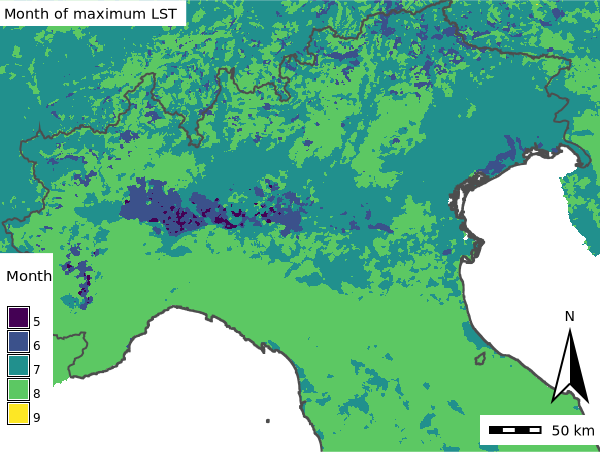
<figcaption aria-hidden="true">Month of maximum LST value</figcaption>
</figure>

## Number of days with LST \>= 20 and \<= 30

Some plague insects tend to thrive in a certain range of temperatures.
Let’s assume this range is from 20 to 30 °C. Here, we’ll estimate the
number of days within this range per year, and then, we’ll estimate the
median along years.

In [14]:
# Keep only pixels meeting the condition
expression="lst_higher20_lower30 = if(lst_daily >= 20.0 && lst_daily <= 30.0, 1, null())"

gs.run_command("t.rast.algebra",
               expression=expression,
               basename="lst_higher20_lower30",
               suffix="gran",
               nproc=6,
               flags="n")

In [15]:
# Count how many times per year the condition is met
gs.run_command("t.rast.aggregate",
               input="lst_higher20_lower30",
               output="count_lst_higher20_lower30",
               basename="count_lst_higher20_lower30",
               suffix="gran",
               method="count",
               granularity="1 years")

In [16]:
# Check raster maps in the STRDS
gs.run_command("t.rast.list",
               input="count_lst_higher20_lower30",
               columns="name,start_time,min,max")

In [17]:
# Median number of days with average lst >= 20 and <= 30
gs.run_command("t.rast.series",
               input="count_lst_higher20_lower30",
               output="median_count_lst_higher20_lower30",
               method="median")

In [18]:
# Display raster map with interactive class
h20_map = gj.InteractiveMap()
h20_map.add_raster("median_count_lst_higher20_lower30")
h20_map.show()

> **Question**
>
> How would you check if the median number of days with lst \>= 20 and
> \<= 30 is changing along the years?

## Number of consecutive days with LST \<= -10.0

Likewise, there are temperature thresholds that mark a limit to insects
survival. Here, we’ll use the lowest temperature threshold. Most
importantly, we we’ll count the number of consecutive days with
temperatures below this threshold.

We’ll use again the temporal algebra and we’ll recall the concept of
topology that we defined at the beginning of these tutorials. First, we
need to create a STRDS of annual granularity that will contain only
zeroes. This annual STRDS, that we call `annual_mask`, will be our base
to add the value 1 each time the condition \< -10 °C in consecutive days
is met. Finally, we estimate the median number of days with LST lower
than -10 °C over the 5 years.

In [19]:
# Create annual mask
gs.run_command("t.rast.aggregate",
               input="lst_daily",
               output="annual_mask",
               basename="annual_mask",
               suffix="gran",
               granularity="1 year",
               method="count")

In [20]:
# Replace values by zero
expression="if(annual_mask, 0)"

gs.run_command("t.rast.mapcalc",
               input="annual_mask",
               output="annual_mask_0",
               expression=expression,
               basename="annual_mask_0")

In [21]:
# Calculate consecutive days with LST <= -10.0
expression="lower_m10_consec_days = annual_mask_0 {+,contains,l} if(lst_daily <= -10.0 && lst_daily[-1] <= -10.0 || lst_daily[1] <= -10.0 && lst_daily <= -10.0, 1, 0)"

gs.run_command("t.rast.algebra",
               expression=expression,
               basename="lower_m10",
               suffix="gran",
               nproc=6)

In [22]:
# Inspect values
gs.run_command("t.rast.list",
               input="lower_m10_consec_days",
               columns="name,start_time,min,max")

In [23]:
# Median number of consecutive days with LST <= -10
gs.run_command("t.rast.series",
               input="lower_m10_consec_days",
               output="median_lower_m10_consec_days",
               method="median")

In [24]:
# Display raster map with interactive class
lt10_map = gj.InteractiveMap()
lt10_map.add_raster("median_lower_m10_consec_days")
lt10_map.show()

## References

-   Gebbert, S., Pebesma, E. 2014. *TGRASS: A temporal GIS for field
    based environmental modeling.* Environmental Modelling & Software
    53, 1-12. [DOI](http://dx.doi.org/10.1016/j.envsoft.2013.11.001).
-   Gebbert, S., Pebesma, E. 2017. *The GRASS GIS temporal framework.*
    International Journal of Geographical Information Science 31,
    1273-1292. [DOI](http://dx.doi.org/10.1080/13658816.2017.1306862).
-   Gebbert, S., Leppelt, T., Pebesma, E., 2019. *A topology based
    spatio-temporal map algebra for big data analysis.* Data 4, 86.
    [DOI](https://doi.org/10.3390/data4020086).
-   [Temporal data
    processing](https://grasswiki.osgeo.org/wiki/Temporal_data_processing)
    wiki page.

------------------------------------------------------------------------

The development of this tutorial was funded by the US [National Science
Foundation (NSF)](https://www.nsf.gov/), award
[2303651](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2303651).